In [1]:
!pip install timm

     |████████████████████████████████| 376 kB 904 kB/s eta 0:00:01


In [2]:
!unzip /kaggle/input/oxford-102-flower-pytorch/flower_data.zip


Archive:  /kaggle/input/oxford-102-flower-pytorch/flower_data.zip
  inflating: flower_data/cat_to_name.json  
   creating: flower_data/test/
  inflating: flower_data/test/image_00005.jpg  
  inflating: flower_data/test/image_00006.jpg  
  inflating: flower_data/test/image_00024.jpg  
  inflating: flower_data/test/image_00025.jpg  
  inflating: flower_data/test/image_00029.jpg  
  inflating: flower_data/test/image_00050.jpg  
  inflating: flower_data/test/image_00060.jpg  
  inflating: flower_data/test/image_00065.jpg  
  inflating: flower_data/test/image_00092.jpg  
  inflating: flower_data/test/image_00099.jpg  
  inflating: flower_data/test/image_00114.jpg  
  inflating: flower_data/test/image_00116.jpg  
  inflating: flower_data/test/image_00132.jpg  
  inflating: flower_data/test/image_00176.jpg  
  inflating: flower_data/test/image_00177.jpg  
  inflating: flower_data/test/image_00187.jpg  
  inflating: flower_data/test/image_00191.jpg  
  inflating: flower_data/test/image_00202.j

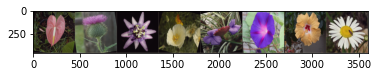

In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import timm


plt.ion()   # interactive mode

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((464,464)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(448),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((448,448)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}


data_dir = 'flower_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                   for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=0)
               for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x])  for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = 'cuda'#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)#, title=[class_names[x] for x in classes])


In [4]:
model_ft = timm.create_model("efficientnet_b1", pretrained=True)
num_ftrs = model_ft.classifier.in_features

half_in_size = round(num_ftrs/2)
layer_width = 1024
Num_class=102


class SpinalNetV1(nn.Module):
    def __init__(self):
        super(SpinalNetV1, self).__init__()
        
        self.fc_spinal_layer1 = nn.Sequential(
            nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size, layer_width),
            nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer2 = nn.Sequential(
            nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer3 = nn.Sequential(
            nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer4 = nn.Sequential(
            nn.Dropout(p = 0.5), 
            nn.Linear(half_in_size+layer_width, layer_width),
            nn.BatchNorm1d(layer_width), 
            nn.ReLU(inplace=True),)
        self.fc_out = nn.Sequential(
            nn.Dropout(p = 0.5), 
            nn.Linear(layer_width*4, Num_class),)
        
    def forward(self, x):
        x1 = self.fc_spinal_layer1(x[:, 0:half_in_size])
        x2 = self.fc_spinal_layer2(torch.cat([ x[:,half_in_size:2*half_in_size], x1], dim=1))
        x3 = self.fc_spinal_layer3(torch.cat([ x[:,0:half_in_size], x2], dim=1))
        x4 = self.fc_spinal_layer4(torch.cat([ x[:,half_in_size:2*half_in_size], x3], dim=1))
        
        
        x = torch.cat([x1, x2], dim=1)
        x = torch.cat([x, x3], dim=1)
        x = torch.cat([x, x4], dim=1)

        
        x = self.fc_out(x)
        return x
    


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b1-533bc792.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-533bc792.pth


In [5]:
model_ft.classifier = SpinalNetV1()

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
 
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                time_elapsed = time.time() - since
                print('Time from Start {:.0f}m {:.0f}s'.format(
                    time_elapsed // 60, time_elapsed % 60))
                
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0008, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
train Loss: 3.0949 Acc: 0.3111
valid Loss: 1.3315 Acc: 0.7286
Time from Start 4m 28s

Epoch 1/29
train Loss: 1.1864 Acc: 0.6975
valid Loss: 0.4556 Acc: 0.9193
Time from Start 8m 55s

Epoch 2/29
train Loss: 0.6356 Acc: 0.8344
valid Loss: 0.2498 Acc: 0.9462
Time from Start 13m 22s

Epoch 3/29
train Loss: 0.4345 Acc: 0.8889
valid Loss: 0.1819 Acc: 0.9584
Time from Start 17m 48s

Epoch 4/29
train Loss: 0.3261 Acc: 0.9116
valid Loss: 0.1217 Acc: 0.9731
Time from Start 22m 14s

Epoch 5/29
train Loss: 0.2599 Acc: 0.9299
valid Loss: 0.1151 Acc: 0.9658

Epoch 6/29
train Loss: 0.2050 Acc: 0.9446
valid Loss: 0.0879 Acc: 0.9792
Time from Start 31m 9s

Epoch 7/29
train Loss: 0.1603 Acc: 0.9608
valid Loss: 0.0979 Acc: 0.9743

Epoch 8/29
train Loss: 0.1447 Acc: 0.9649
valid Loss: 0.0891 Acc: 0.9780

Epoch 9/29
train Loss: 0.1431 Acc: 0.9650
valid Loss: 0.0772 Acc: 0.9853
Time from Start 44m 28s

Epoch 10/29
train Loss: 0.1417 Acc: 0.9643
valid Loss: 0.0800 Acc: 0.9841

Epoch 11/29
train Lo

In [8]:
nb_classes = 102

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['valid']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[ 8.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  4.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  6.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  7.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0., 10.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  6.]])


Text(0.5, 159.0, 'Predicted label')

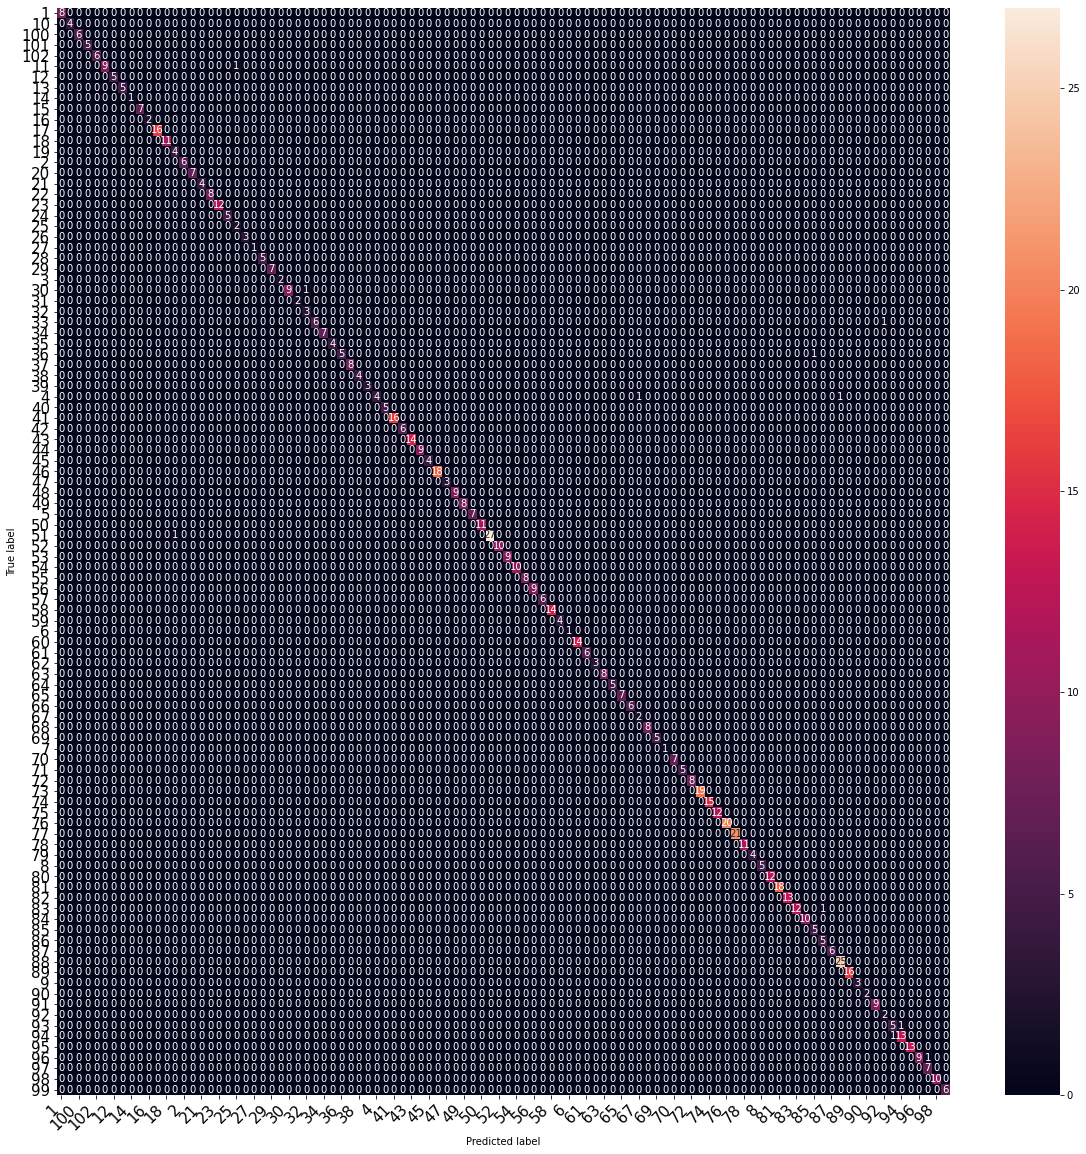

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns

plt.figure(figsize=(20,20))
class_names = list(image_datasets['valid'].classes)
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [10]:
recall = np.diag(df_cm) / np.sum(df_cm, axis = 1)
precision = np.diag(df_cm) / np.sum(df_cm, axis = 0)

In [11]:
print("Recall")
print(recall)
print(recall.mean())


print("\nPresisi")
print(precision)
print(precision.mean())

Recall
1      1.0
10     1.0
100    1.0
101    1.0
102    1.0
      ... 
95     1.0
96     0.9
97     1.0
98     1.0
99     1.0
Length: 102, dtype: float64
0.9873177476118652

Presisi
1      1.000
10     1.000
100    1.000
101    1.000
102    1.000
       ...  
95     1.000
96     1.000
97     0.875
98     1.000
99     1.000
Length: 102, dtype: float64
0.9785795087265676


In [12]:
!pip install disarray

In [13]:
import disarray
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

print('accuracy: {:3f}'.format(accuracy(confusion_matrix)))
print('precision: {:3f}'.format(df_cm.da.precision.mean()))
print('recall: {:3f}'.format(df_cm.da.recall.mean()))
print('f1: {:3f}'.format(df_cm.da.f1.mean()))

accuracy: 0.986553
precision: 0.978580
recall: 0.987318
f1: 0.980941


In [14]:
!pip install openpyxl
df_cm.to_excel('TS1_TResNet_SpinalNet_test_confusion_matrix.xlsx')

     |████████████████████████████████| 243 kB 877 kB/s eta 0:00:01
